In [62]:
# Author: Arthur Prigent
# Email: aprigent@geomar.de

#### DATA ####
# https://downloads.psl.noaa.gov/Datasets/
    

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import xscale.signal.fitting as xsf
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
now = datetime.now()
date_time = now.strftime("%d/%m/%Y")

def ano_norm_t(ds):
    
    '''Compute the anomalies by removing the monthly means. 
    The anomalies are normalized by their corresponding month.
    
    Parameters
    ----------
    
    ds : xarray_like
    Timeserie or 3d field.
    
    Returns
    -----------
    
    ano : xarray_like
    Returns the anomalies of var relative the climatology.
    
    ano_norm : xarray_like
    Returns the anomalies of var relative the climatology normalized by the standard deviation.
    
    '''    

    clim     = ds.groupby('time.month').mean('time')
    clim_std = ds.groupby('time.month').std('time')
    ano      = ds.groupby('time.month') - clim
    ano_norm = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                    ds.groupby('time.month'),
                                    clim, clim_std)
    
    return ano, ano_norm 

def ano_norm_t_wk(ds):
    
    '''Compute the anomalies by removing the monthly means. 
    The anomalies are normalized by their corresponding month.
    
    Parameters
    ----------
    
    ds : xarray_like
    Timeserie or 3d field.
    
    Returns
    -----------
    
    ano : xarray_like
    Returns the anomalies of var relative the climatology.
    
    ano_norm : xarray_like
    Returns the anomalies of var relative the climatology normalized by the standard deviation.
    
    '''    

    clim     = ds.groupby('time.week').mean('time')
    clim_std = ds.groupby('time.week').std('time')
    ano      = ds.groupby('time.week') - clim
    ano_norm = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                    ds.groupby('time.week'),
                                    clim, clim_std)
    
    return ano, ano_norm 


def read_data_compute_anomalies_week(path_data):
    
    ds = xr.open_dataset(path_data+'sst.wkmean.1990-present.nc',engine='pydap')
    mask = xr.open_dataset(path_data+'lsmask.nc',engine='pydap')
    ds = ds.sst.where(mask.mask[0,:,:]==1)
    sst= ds.sel(time=slice(datetime(1990, 1, 1), now))
    sst = xr.concat([sst[:, :, 180:], sst[:, :, :180]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    
    
    sst_atl3 = sst_atl3.chunk(chunks=None)
    sst_atl3_dtd = xsf.detrend(sst_atl3,dim='time',type='linear')
    
    sst_aba = sst_aba.chunk(chunks=None)
    sst_aba_dtd = xsf.detrend(sst_aba,dim='time',type='linear')
    
    
    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t_wk(sst_atl3_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t_wk(sst_aba_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm


def read_data_compute_anomalies_oi(path_data):
    
    ds = xr.open_dataset(path_data+'sst.mnmean.nc',engine='pydap')
    mask = xr.open_dataset(path_data+'lsmask.nc',engine='pydap')
    ds = ds.sst.where(mask.mask[0,:,:]==1)
    sst= ds.sel(time=slice(datetime(1982, 1, 1), now))
    sst = xr.concat([sst[:, :, 180:], sst[:, :, :180]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    
    
    sst_atl3 = sst_atl3.chunk(chunks=None)
    sst_atl3_dtd = xsf.detrend(sst_atl3,dim='time',type='linear')
    
    sst_aba = sst_aba.chunk(chunks=None)
    sst_aba_dtd = xsf.detrend(sst_aba,dim='time',type='linear')
    
    
    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm



def read_data_compute_anomalies(path_data):
    
    ds = xr.open_dataset(path_data,engine='pydap')
    sst= ds.sst.sel(time=slice(datetime(1982, 1, 1), now))
    sst = xr.concat([sst[:, :, 180:], sst[:, :, :180]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    
    
    sst_atl3 = sst_atl3.chunk(chunks=None)
    sst_atl3_dtd = xsf.detrend(sst_atl3,dim='time',type='linear')
    
    sst_aba = sst_aba.chunk(chunks=None)
    sst_aba_dtd = xsf.detrend(sst_aba,dim='time',type='linear')
    
    
    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm


def read_data_compute_anomalies_ersstv5(path_data):
    
    ds = xr.open_dataset(path_data,engine='pydap')
    sst= ds.sst.sel(time=slice(datetime(1982, 1, 1), now))
    sst = xr.concat([sst[:, :, 90:], sst[:, :, :90]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    
    
    sst_atl3 = sst_atl3.chunk(chunks=None)
    sst_atl3_dtd = xsf.detrend(sst_atl3,dim='time',type='linear')
    
    sst_aba = sst_aba.chunk(chunks=None)
    sst_aba_dtd = xsf.detrend(sst_aba,dim='time',type='linear')
    
    
    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm




def plot_anomalies(ssta_atl3,ssta_aba):
    
    f,ax = plt.subplots(2,1,figsize=[15,10])
    color_lines='grey'
    ftz=15
    ax=ax.ravel()

    
    ### ATL3 ###
    ax[0].axhline(0,color=color_lines)
    ax[0].axhline(1,color=color_lines,linestyle='--')
    ax[0].axhline(-1,color=color_lines,linestyle='--')
    ax[0].plot(ssta_atl3.time.values,ssta_atl3,color='black')
    years = mdates.YearLocator(5)   # every year
    years_minor = mdates.YearLocator(1)  # every month
    ax[0].xaxis.set_major_locator(years)
    ax[0].xaxis.set_minor_locator(years_minor)
    myFmt = mdates.DateFormatter('%Y')
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].tick_params(labelsize=ftz)
    ax[0].fill_between(ssta_atl3.time.values,ssta_atl3,1,ssta_atl3>1,color='red')
    ax[0].fill_between(ssta_atl3.time.values,ssta_atl3,-1,ssta_atl3<-1,color='blue')
    ax[0].set_title('Normalized SST anomalies ATL3 [20$^{\circ}$W-0; 3$^{\circ}$S-3$^{\circ}$N] | Baseline '+str(ssta_atl3.time.values[0])[:7] +' --> '+str(ssta_atl3.time.values[-1])[:7],fontsize=ftz,fontweight='bold')
    ax[0].text(0.01,0.04,'Updated '+date_time,transform=ax[0].transAxes,
           size=ftz,
           weight='bold')
    ax[0].set_ylim([-3,3])
    
    
   
    
    ### ABA ###
    ax[1].set_title('Normalized SST anomalies ABA [8$^{\circ}$E-16$^{\circ}$E; 20$^{\circ}$S-10$^{\circ}$S] | Baseline '+str(ssta_aba.time.values[0])[:7] +' --> '+str(ssta_aba.time.values[-1])[:7],fontsize=ftz,fontweight='bold')
    ax[1].plot(ssta_aba.time,ssta_aba,color='black')
    ax[1].axhline(0,color=color_lines)
    ax[1].axhline(1,color=color_lines,linestyle='--')
    ax[1].axhline(-1,color=color_lines,linestyle='--')
    ax[1].text(0.01,0.04,'Updated '+date_time,transform=ax[1].transAxes,
           size=ftz,
           weight='bold')
    years = mdates.YearLocator(5)   # every 5 years
    years_minor = mdates.YearLocator(1)  # every year
    ax[1].xaxis.set_major_locator(years)
    ax[1].xaxis.set_minor_locator(years_minor)
    myFmt = mdates.DateFormatter('%Y')
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].tick_params(labelsize=ftz)
    ax[1].fill_between(ssta_aba.time.values,ssta_aba,1,ssta_aba>1,color='red')
    ax[1].fill_between(ssta_aba.time.values,ssta_aba,-1,ssta_aba<-1,color='blue')
    ax[1].set_ylim([-3,3])
    
    


# Read SST data 

In [64]:
path_oi_wk = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
ssta_atl3_norm_oi_wk,ssta_aba_norm_oi_wk = read_data_compute_anomalies_week(path_oi_wk)

/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,
/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,
/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,
/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,
/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please us

In [65]:
path_data = 'https://psl.noaa.gov/thredds/dodsC/Datasets/COBE/sst.mon.mean.nc'
ssta_atl3_norm_cobe,ssta_aba_norm_cobe = read_data_compute_anomalies(path_data)


/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,
/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,


In [66]:
path_oi = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
ssta_atl3_norm_oi,ssta_aba_norm_oi = read_data_compute_anomalies_oi(path_oi)

/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,
/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,


In [67]:
path_ersstv5 = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ssta_atl3_norm_ersst,ssta_aba_norm_ersst = read_data_compute_anomalies_ersstv5(path_ersstv5)

/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,
/anaconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataset.py:2039: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,


# Timeseries of SST anomalies

# Monthly data

# COBE SST

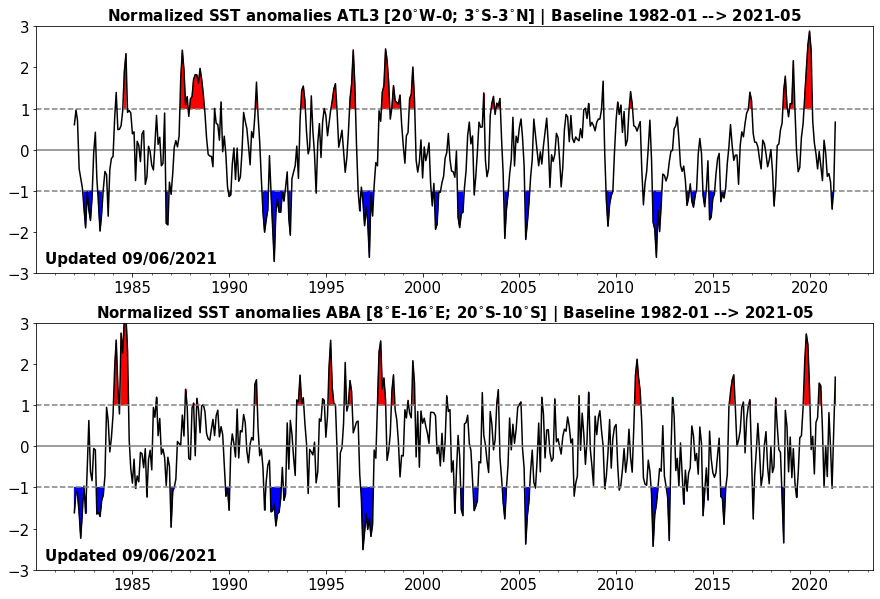

In [68]:
plot_anomalies(ssta_atl3_norm_cobe,ssta_aba_norm_cobe)

# OI SST v2

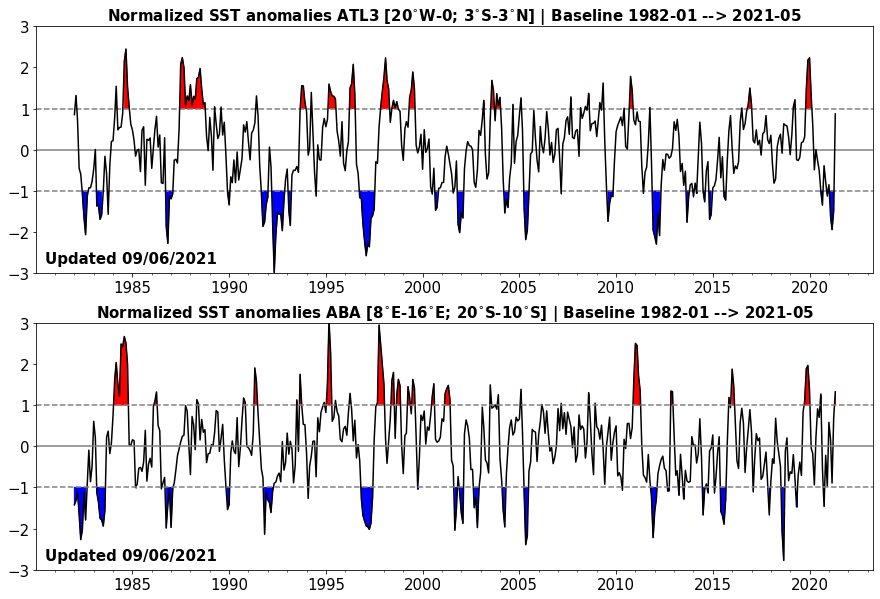

In [69]:
plot_anomalies(ssta_atl3_norm_oi,ssta_aba_norm_oi)

# ERSST V5 

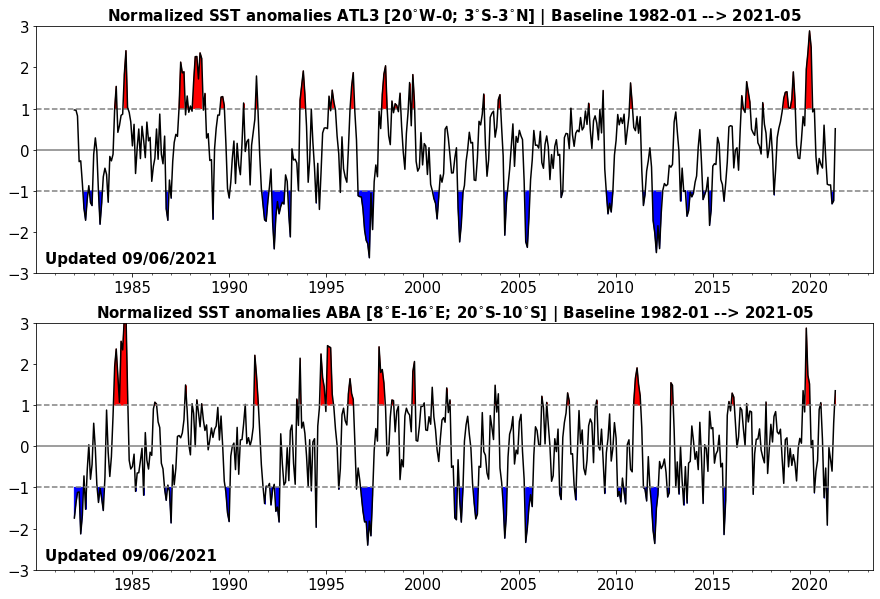

In [70]:
plot_anomalies(ssta_atl3_norm_ersst,ssta_aba_norm_ersst)

# Weekly data

## OI SST v2/ weekly, Baseline 1990-present

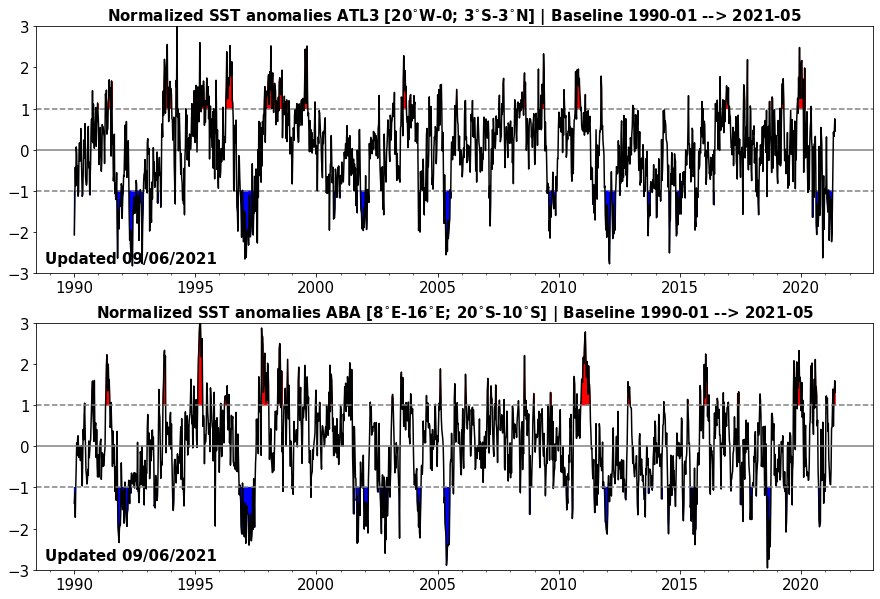

In [71]:
plot_anomalies(ssta_atl3_norm_oi_wk,ssta_aba_norm_oi_wk)